In [1]:
## Importing Libraries

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

import xgboost as xgb
import joblib
import os

In [2]:
## Loading Dataset

print("Loading Default of Credit Card Clients dataset...")
# https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients
data = fetch_openml(data_id=42477, as_frame=True, parser='auto')
X = data.data
y = data.target
# Sampling 50% of the dataset for using a smaller dataset
X = X.sample(frac=0.5, random_state=42)
y = y.loc[X.index]
X.shape, y.shape

Loading Default of Credit Card Clients dataset...


((15000, 23), (15000,))

In [3]:
## Data Preprocessing

if y.dtype == 'category' or y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train.shape, X_test.shape

((12000, 23), (3000, 23))

In [4]:
## Save test data as CSV for github

# Combine X_test and y_test into one DataFrame for easy viewing
test_df = pd.DataFrame(X_test, columns=X.columns)
test_df['target'] = y_test
# Create a directory for data if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')
test_path = 'data/test_dataset.csv'
test_df.to_csv(test_path, index=False)
print(f"Test dataset saved to: {test_path}")

Test dataset saved to: data/test_dataset.csv


In [5]:
## Training Models

# Create model directory if it doesn't exist
if not os.path.exists('model'):
    os.makedirs('model')

# Define Models
models = {
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    "Decision_Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive_Bayes": GaussianNB(),
    "Random_Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}
print("Training and saving models...")

for name, model in models.items():
    print(f"Training {name}...")
    # Use scaled data for LR and KNN
    if name in ["Logistic_Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)
    # Save model
    filename = f'model/{name}.pkl'
    joblib.dump(model, filename)
    print(f"Saved {filename}")
print("All models trained and saved successfully.")

# Also Save the scaler for future use
joblib.dump(scaler, 'model/scaler.pkl')

Training and saving models...
Training Logistic_Regression...
Saved model/Logistic_Regression.pkl
Training Decision_Tree...
Saved model/Decision_Tree.pkl
Training KNN...
Saved model/KNN.pkl
Training Naive_Bayes...
Saved model/Naive_Bayes.pkl
Training Random_Forest...
Saved model/Random_Forest.pkl
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:50:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved model/XGBoost.pkl
All models trained and saved successfully.


['model/scaler.pkl']

In [6]:
# List to store results
results = []

print("Evaluating models with AUC scores...")

for name, model in models.items():
    # 1. Select the correct data (Scaled vs Unscaled)
    current_X_test = X_test_scaled if name in ["Logistic_Regression", "KNN"] else X_test

    # 2. Generate predictions
    y_pred = model.predict(current_X_test)

    # 3. Generate probabilities for AUC (CRUCIAL STEP)
    # We take the probabilities for the positive class (column 1)
    y_prob = model.predict_proba(current_X_test)[:, 1]

    # 4. Calculate metrics
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC Score": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        "MCC": matthews_corrcoef(y_test, y_pred)
    })

# 5. Display Table
results_df = pd.DataFrame(results)
display(results_df)

Evaluating models with AUC scores...


,Model,Accuracy,AUC Score,Precision,Recall,F1-Score,MCC
0,Logistic_Regression,0.811667,0.711293,0.793326,0.811667,0.775107,0.334099
1,Decision_Tree,0.818667,0.739822,0.800376,0.818667,0.798555,0.391687
2,KNN,0.792333,0.688276,0.768852,0.792333,0.774197,0.310923
3,Naive_Bayes,0.390000,0.666965,0.734845,0.390000,0.394256,0.119278
4,Random_Forest,0.811333,0.745808,0.791051,0.811333,0.791785,0.368427
5,XGBoost,0.807333,0.736286,0.787304,0.807333,0.790232,0.362582



MODEL: Logistic_Regression
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2345
           1       0.69      0.25      0.37       655

    accuracy                           0.81      3000
   macro avg       0.76      0.61      0.63      3000
weighted avg       0.79      0.81      0.78      3000



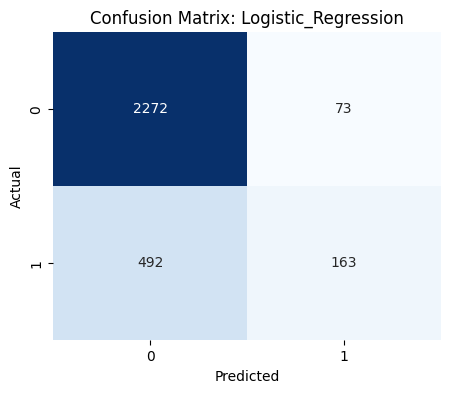


MODEL: Decision_Tree
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2345
           1       0.65      0.37      0.47       655

    accuracy                           0.82      3000
   macro avg       0.75      0.66      0.68      3000
weighted avg       0.80      0.82      0.80      3000



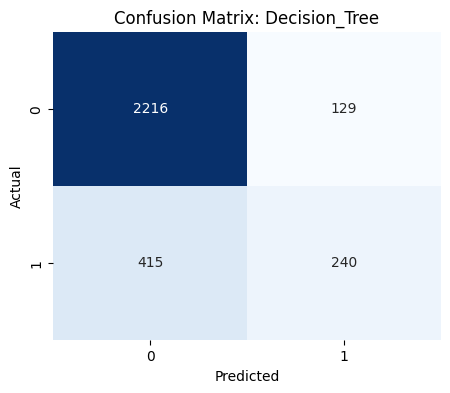


MODEL: KNN
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2345
           1       0.54      0.34      0.42       655

    accuracy                           0.79      3000
   macro avg       0.69      0.63      0.65      3000
weighted avg       0.77      0.79      0.77      3000



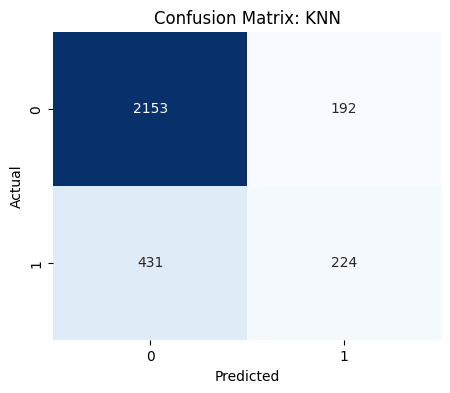


MODEL: Naive_Bayes
              precision    recall  f1-score   support

           0       0.87      0.26      0.40      2345
           1       0.25      0.86      0.38       655

    accuracy                           0.39      3000
   macro avg       0.56      0.56      0.39      3000
weighted avg       0.73      0.39      0.39      3000



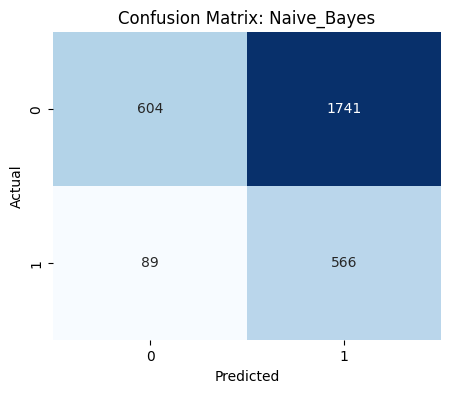


MODEL: Random_Forest
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2345
           1       0.62      0.36      0.45       655

    accuracy                           0.81      3000
   macro avg       0.73      0.65      0.67      3000
weighted avg       0.79      0.81      0.79      3000



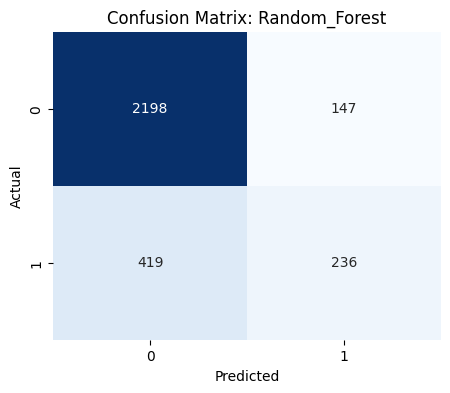


MODEL: XGBoost
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      2345
           1       0.59      0.37      0.46       655

    accuracy                           0.81      3000
   macro avg       0.72      0.65      0.67      3000
weighted avg       0.79      0.81      0.79      3000



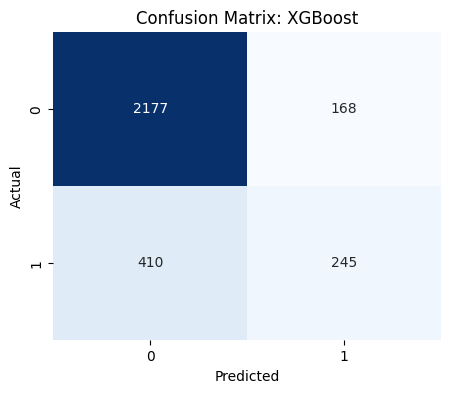

In [7]:
# Classification Report and Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

for name, model in models.items():
    # 1. Select the correct data
    current_X_test = X_test_scaled if name in ["Logistic_Regression", "KNN"] else X_test
    y_pred = model.predict(current_X_test)

    print(f"\n{'='*30}")
    print(f"MODEL: {name}")
    print(f"{'='*30}")

    # 2. Classification Report
    print(classification_report(y_test, y_pred))

    # 3. Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()